In [1]:
from torchvision.utils import save_image
import pandas as pd
from PIL import Image

from osgeo import gdal, osr, ogr

import os

import matplotlib.pyplot as plt
import matplotlib.image as pimage
import numpy as np
import torch

from gtif import *
from dataPreprocess import *

c:\users\mouju\appdata\local\programs\python\python38\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
RE = 6371000 #radius of earth
chips_layer_names = []

df = pd.read_csv(r"C:\Users\mouju\Desktop\film\components_analysis\df_unique.csv", header=[0])
project_df(df)

In [5]:
len(df)

561

In [3]:
df.proj_x.max()

-2259865.6402677717

In [4]:
df.proj_x.min()

-2369689.1843294236

In [5]:
df.proj_y.min()

-83636.26810386151

In [6]:
df.proj_y.max()

-48035.44244709332

In [7]:
# crop_hds_discard_chips(df)

Number of boreholes: 84


In [6]:


df.borehole = df.borehole.str.replace('//', '--')

file = r"C:\Users\mouju\Desktop\film\hds\geotiff_original\ldcorr_refine.tif"
ds = gdal.Open(file)
ulx, xres, xskew, uly, yskew, yres  = ds.GetGeoTransform()

band = ds.GetRasterBand(1)
arr = band.ReadAsArray()

# df = crop_df_hds(df)

print(f'Number of boreholes: {len(df)}')

Number of boreholes: 561


In [25]:
df = df.query("borehole != 'ENG.YARC03097-01--HUS_H (NTGS 7)'")
print(f'Number of boreholes: {len(df)}')

Number of boreholes: 560


In [9]:
# df['borehole_group'] = df['borehole'].str.split('-').str[0]

# df=df.query("borehole_group != '2.45'")

# df=df.query("borehole_group != 'GSC3 '")

# df=df.query("borehole_group != 'GSC4 '")

# df=df.query("borehole != 'ENG.YARC03097-01--ITH-02'")
# df=df.query("borehole != 'ENG.YARC03097-01--ITH-03'")

# df=df.query("borehole != 'ENG.YARC03097-01--ITH-04'")

# df=df.query("borehole != 'W14103137-CR18N'")
# df=df.query("borehole != 'W14103137-CR18S'")
# df=df.query("borehole != 'W14103137-CR21N'")
# df=df.query("borehole != 'W14103137-CR21S'")

In [7]:
print(f'Number of boreholes: {len(df)}')

Number of boreholes: 561


In [10]:
# make sure boreholes fall within hds region

# # plt.fig()
# plt.imshow(arr)
# plt.colorbar()
# plt.title(file)
# ax = plt.gca()
# ax.get_yaxis().set_visible(False)
# ax.get_xaxis().set_visible(False)

# x_scatter = (df.longitude - ulx) / xres
# y_scatter = (uly - df.latitude)/(-yres)
# plt.scatter(x_scatter, y_scatter,c='r')
# plt.show()

# ARCTICDEM

In [8]:
chip_size = 128

data_root = r"C:\Users\mouju\Desktop\film\saga_data"

chips_root = r"C:\Users\mouju\Desktop\film\raster_chips\arcticdem"
if not os.path.exists(chips_root):
    os.makedirs(chips_root)

chips_image_root = chips_root + "_images"

if not os.path.exists(chips_image_root):
    os.makedirs(chips_image_root)

n_channels = len(os.listdir(data_root)) // 2

# base_lat = 70
# base_lng = -135


# # lenght along meridians
# pixel_len_lat = 5/180 * np.pi /6000 * RE # in meters
# chip_size_m = 5000 # chip size in meters
# chip_size_lat = round(chip_size_m/pixel_len_lat/2) * 2 # making sure chip_size is even

n_pixels = 10000
base_x = -2399995
preloaded = np.zeros([n_channels, n_pixels, n_pixels*2])
file_list = os.listdir(data_root)

In [12]:
channel_names_list = ['dem', 'insolation', 'twi']

In [9]:
for i in range(n_channels):
    # name = file.split('_')[0]
    # print(name)
    f_17 = os.path.join(data_root, file_list[i*2])
    f_18 = os.path.join(data_root, file_list[i*2 + 1])
    
    arr17, extent17, _ = read_geotiff(f_17, 1)
    
    #print(extent17)
    arr18, _, _ = read_geotiff(f_18, 1)
    
    preloaded[i, :, 0:10000] = arr17
    preloaded[i,:, 10000:20000] = arr18
    
    channel_name = file_list[i*2].split('_')[0]
    chips_layer_names.append(channel_name)

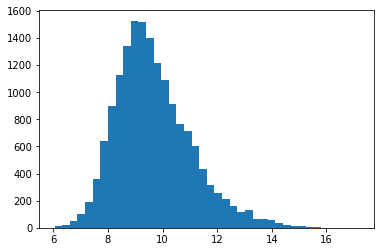

In [10]:
plt.figure()
for _, row in df.iterrows():
    
    x = row.at['proj_x']
    y = row.at['proj_y']
    bh = row.borehole

    pixel_len = 10


    # (df17.proj_x + 2400000) / 10, (-df17.proj_y)/10

    x_start = np.round((x - base_x) / pixel_len - chip_size/2).astype(int)
    x_end = x_start + chip_size

    y_start = np.round((- y) / pixel_len - chip_size/2).astype(int)
    y_end = y_start + chip_size
    
#     print(x, base_x)
#     print(x - base_x)
    # print(x_start,x_end,y_start,y_end)
    
    if (y_end - y_start < chip_size) or (x_end - x_start < chip_size):
        print(f'chip size of {bh} smaller than desired chip size')
    
    image= preloaded[:, y_start:y_end, x_start:x_end]
    
    with open(os.path.join(chips_root, f'{bh}.npy'), 'wb') as f:
        np.save(f, image)
    
    for i in range(n_channels):
        channel_name = file_list[i*2].split('_')[0]
        
        channel_path = os.path.join(chips_image_root, channel_name)
        if not os.path.exists(channel_path):
            os.makedirs(channel_path)
        
        pimage.imsave(os.path.join(channel_path, f'{bh}.png'), image[i,:,:])
        
        plt.clf()
        plt.hist(image[i,:,:].flatten(), bins=40)
        plt.savefig(os.path.join(channel_path, f'{bh}_hist.png'))
    

# HDS (rgb channels?)

In [11]:
chip_size = 128
data_root = r"C:\Users\mouju\Desktop\film\hds\epsg3413_10m_lanczos"
chips_root = r"C:\Users\mouju\Desktop\film\raster_chips\hds"
if not os.path.exists(chips_root):
    os.makedirs(chips_root)
print_progress = False

In [12]:
file_list = os.listdir(data_root)
# file_list_rgb = []
# for f in file_list:
#     for colour in ['r', 'g', 'b']:
#         file_list_rgb.append(f.split('_')[0] + '_' + colour)
n_channels = len(file_list*3)

f = os.path.join(data_root, file_list[0])
arr, extent, _ = read_geotiff(f, 1)
ulx, xres, xskew, uly, yskew, yres = extent

preloaded = np.zeros([n_channels, arr.shape[0], arr.shape[1]])
print(f"xres = {xres}, yres = {yres}, ulx = {ulx}, uly = {uly}")

channel_names_list = []
for i, file in enumerate(file_list):
    name = file.split('_')[0]
    f = os.path.join(data_root, file)
    for c_ind, colour in enumerate(['r', 'g', 'b']):
        channel_names_list.append(name + "_" + colour)
        arr, extent, _ = read_geotiff(f, c_ind+1)
        preloaded[i*3 + c_ind, :, :] = arr

xres = 10.0, yres = -10.0, ulx = -2358227.0324422084, uly = -45050.27319812629


In [13]:
channel_names_list

['ldcorr_r', 'ldcorr_g', 'ldcorr_b', 'tdpcorr_r', 'tdpcorr_g', 'tdpcorr_b']

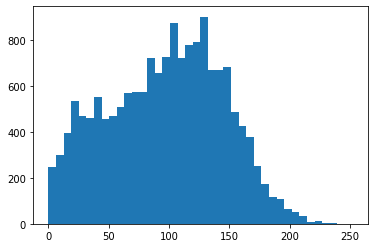

In [14]:
plt.figure()
for bh_ind, row in df.iterrows():
    
    x = row.at['proj_x']
    y = row.at['proj_y']
    bh = row.borehole
    if print_progress:
        print(f"borehole {bh_ind} {bh}")

    x_start = np.round((x - ulx) / xres - chip_size/2).astype(int)
    x_end = x_start + chip_size

    y_start = np.round((y - uly) / yres - chip_size/2).astype(int)
    y_end = y_start + chip_size
    
    if (y_end - y_start < chip_size) or (x_end - x_start < chip_size):
        print(f'chip size of {bh} smaller than desired chip size')


    image= preloaded[:, y_start:y_end, x_start:x_end]
    with open(os.path.join(chips_root, f'{bh}.npy'), 'wb') as f:
        np.save(f, image)
    
    for i in range(n_channels):
        channel_name = channel_names_list[i]
        if print_progress:
            print(f'channel {channel_name}')
        channel_path = os.path.join(chips_root+'_images', channel_name)
        if not os.path.exists(channel_path):
            os.makedirs(channel_path)
        
        pimage.imsave(os.path.join(channel_path, f'{bh}.png'), image[i,:,:])
        
        plt.clf()
        plt.hist(image[i,:,:].flatten(), bins=40)
        plt.savefig(os.path.join(channel_path, f'{bh}_hist.png'))

# GEO 90

In [ ]:
# intakes raster layers already in epsg 3413 coordinate, 10m resolution

In [19]:
chip_size = 128
data_root = r"C:\Users\mouju\Desktop\film\geomorph_data_epsg3413_10m"
chips_root = r"C:\Users\mouju\Desktop\film\raster_chips\geo90"
if not os.path.exists(chips_root):
    os.makedirs(chips_root)
print_progress = True

In [20]:
file_list = os.listdir(data_root)
n_channels = len(file_list)

f = os.path.join(data_root, file_list[0])
arr, extent, _ = read_geotiff(f, 1)
ulx, xres, xskew, uly, yskew, yres = extent

preloaded = np.zeros([n_channels, arr.shape[0], arr.shape[1]])
print(f"xres = {xres}, yres = {yres}, ulx = {ulx}, uly = {uly}")

channel_names_list = []
for i, file in enumerate(file_list):
    name = file.split('_')[0]
    channel_names_list.append(name)
    f = os.path.join(data_root, file)
    arr, extent, _ = read_geotiff(f, 1)
    
    preloaded[i, :, :] = arr

xres = 10.0, yres = -10.0, ulx = -2371005.0, uly = -47000.0


borehole 0 0170-1-10
channel aspect-cosine
channel aspect-sine
channel aspect
channel convergence
channel cti
channel dev-magnitude
channel dev-scale
channel dxx
channel dxy
channel dx
channel dyy
channel dy
channel eastness
channel elev-stdev
channel northness
channel pcurv
channel rough-magnitude
channel rough-scale
channel roughness
channel slope
channel spi
channel tcurv
channel tpi
channel tri
channel vrm
borehole 1 0170-1-12
channel aspect-cosine
channel aspect-sine
channel aspect
channel convergence
channel cti
channel dev-magnitude
channel dev-scale
channel dxx
channel dxy
channel dx
channel dyy
channel dy
channel eastness
channel elev-stdev
channel northness
channel pcurv
channel rough-magnitude
channel rough-scale
channel roughness
channel slope
channel spi
channel tcurv
channel tpi
channel tri
channel vrm
borehole 2 0170-1-17
channel aspect-cosine
channel aspect-sine
channel aspect
channel convergence
channel cti
channel dev-magnitude
channel dev-scale
channel dxx
channel dx

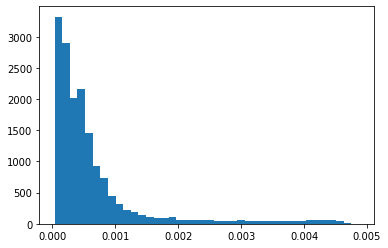

In [21]:
plt.figure()
for bh_ind, row in df.iterrows():
    
    x = row.at['proj_x']
    y = row.at['proj_y']
    bh = row.borehole
    if print_progress:
        print(f"borehole {bh_ind} {bh}")

    x_start = np.round((x - ulx) / xres - chip_size/2).astype(int)
    x_end = x_start + chip_size

    y_start = np.round((y - uly) / yres - chip_size/2).astype(int)
    y_end = y_start + chip_size
    
    if (y_end - y_start < chip_size) or (x_end - x_start < chip_size):
        print(f'chip size of {bh} smaller than desired chip size')


    image= preloaded[:, y_start:y_end, x_start:x_end]
    with open(os.path.join(chips_root, f'{bh}.npy'), 'wb') as f:
        np.save(f, image)
    
    for i in range(n_channels):
        channel_name = file_list[i].split('_')[0]
        if print_progress:
            print(f'channel {channel_name}')
        channel_path = os.path.join(chips_root+'_images', channel_name)
        if not os.path.exists(channel_path):
            os.makedirs(channel_path)
        
        pimage.imsave(os.path.join(channel_path, f'{bh}.png'), image[i,:,:])
        
        plt.clf()
        plt.hist(image[i,:,:].flatten(), bins=40)
        plt.savefig(os.path.join(channel_path, f'{bh}_hist.png'))

# Normalize chips

Channel aspect-cosine has mean 0.010538421136768991 and std 0.6351378750107705
Channel aspect-sine has mean -0.11471859910804762 and std 0.6392393472220549
Channel aspect has mean 201.69367652522936 and std 93.55190323135936
Channel convergence has mean -0.43450047215317006 and std 22.83279082377227
Channel cti has mean -0.7552158355470515 and std 1.8469205215163045
Channel dev-magnitude has mean 0.29876790353914995 and std 1.2017767866302045
Channel dev-scale has mean 737.5412008730777 and std 1275.2466328185405
Channel dxx has mean 1.875891954451344e-06 and std 0.0002668028840449092
Channel dxy has mean -1.7205688457019655e-06 and std 0.00013762594804450867
Channel dx has mean -0.006103585249541374 and std 0.033394238758236466
Channel dyy has mean 1.1331358194381636e-06 and std 0.00025665366573467927
Channel dy has mean 0.003017367972912826 and std 0.03317392171921407
Channel eastness has mean -0.006086616506514984 and std 0.033253391879657375
Channel elev-stdev has mean 3.6239852548

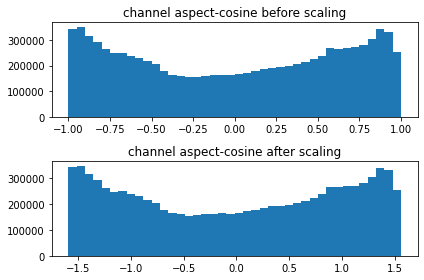

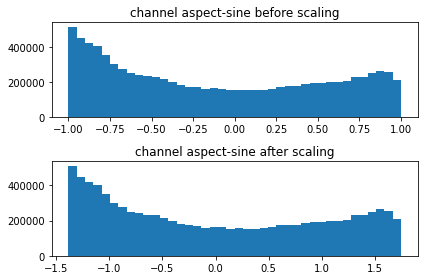

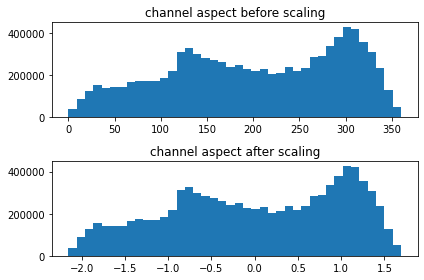

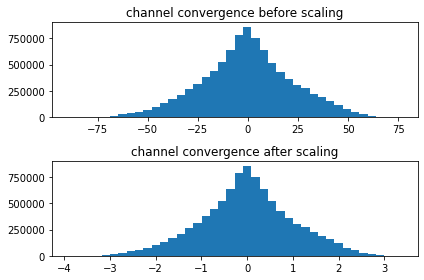

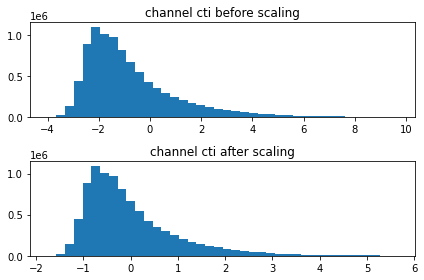

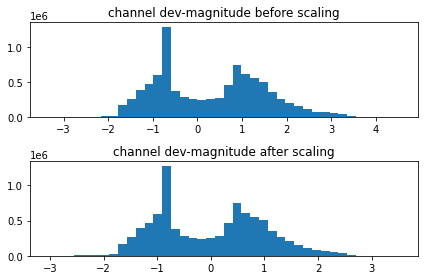

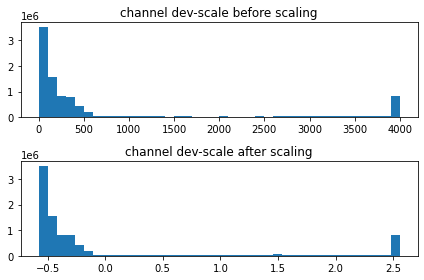

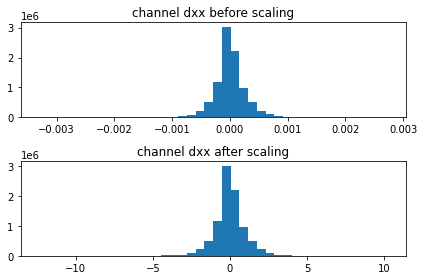

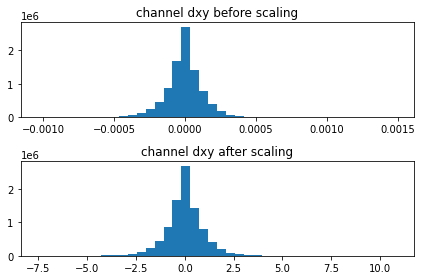

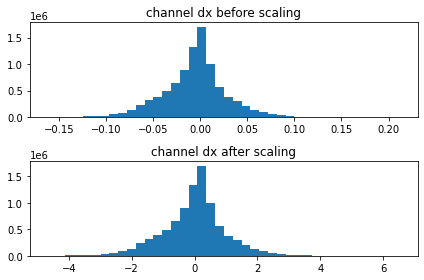

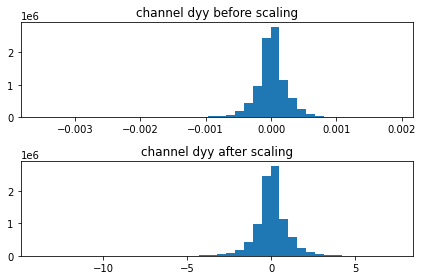

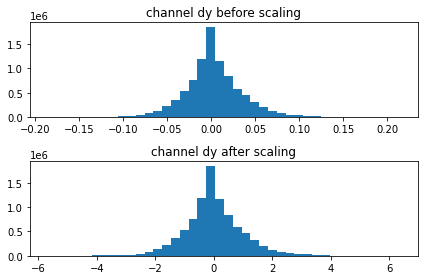

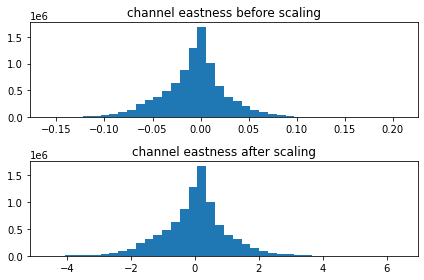

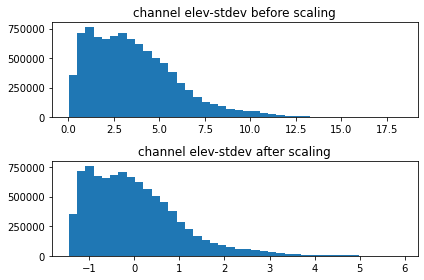

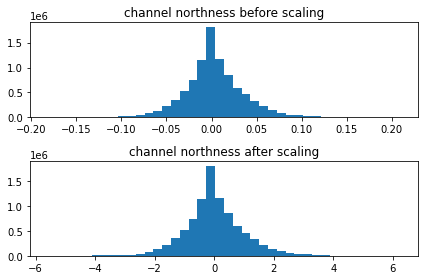

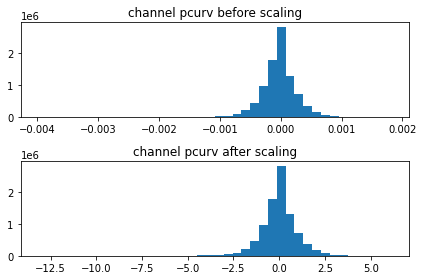

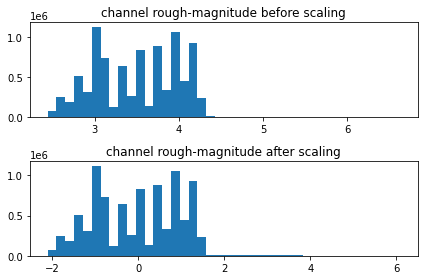

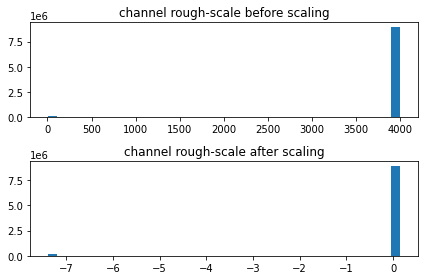

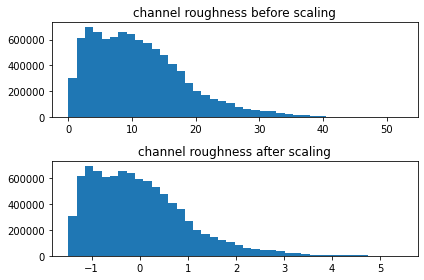

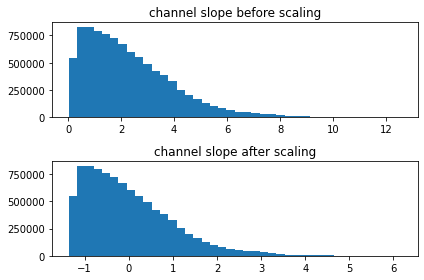

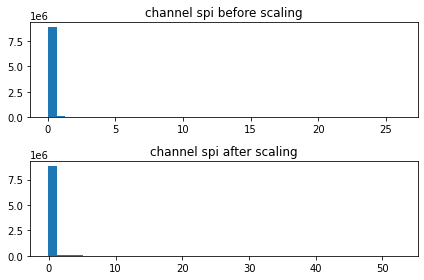

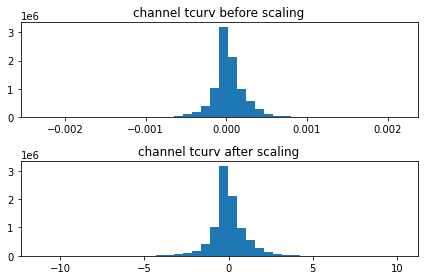

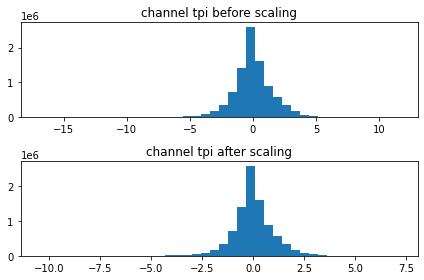

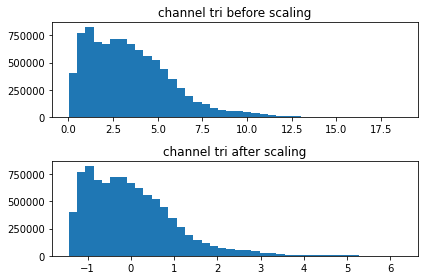

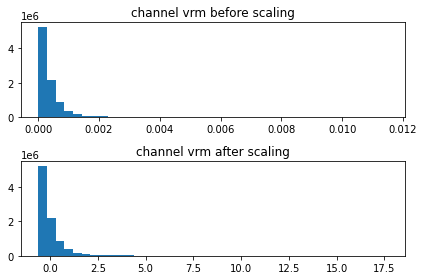

In [23]:
normalize_chips(chips_root, channel_names_list)

# concatenate chips

In [26]:
chips_rootdir = r"C:\Users\mouju\Desktop\film\raster_chips"

# put reference set in first index
chips_names = ['geo90_scaled', 'arcticdem_scaled']

chips_concat_dir = r"C:\Users\mouju\Desktop\film\raster_chips\concat_geo90_arcticdem"

def join_paths(x):
    return os.path.join(chips_rootdir,x)

chips_list = list(map(join_paths, chips_names))

In [27]:
chips_list

['C:\\Users\\mouju\\Desktop\\film\\raster_chips\\geo90_scaled',
 'C:\\Users\\mouju\\Desktop\\film\\raster_chips\\arcticdem_scaled']

In [28]:
test_dir = chips_list[0]
test_file = os.listdir(test_dir)[0]
test_f = os.path.join(test_dir, test_file)
arr = np.load(test_f)
arr.shape

(25, 128, 128)

In [29]:
if not os.path.exists(chips_concat_dir):
    os.makedirs(chips_concat_dir)

for file in os.listdir(chips_list[0]):
    holder = []
    for subdir in chips_list:
        f = os.path.join(subdir, file)
        arr = np.load(f)
        holder.append(arr)
    arr_concat = np.concatenate(holder, axis=0)
    np.save(os.path.join(chips_concat_dir, file), arr_concat)

In [30]:
test_dir = chips_concat_dir
test_file = os.listdir(test_dir)[0]
test_f = os.path.join(test_dir, test_file)
arr = np.load(test_f)
arr.shape

(28, 128, 128)